In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pmdarima import auto_arima
import datetime
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols 
from statsmodels.tsa.arima_model import ARIMA, ARMA, ARMAResults, ARIMAResults 
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

In [2]:
dem = pd.concat(map(pd.read_csv, ['C:/Users/abuka/Desktop/Baba_Desk/ABU_Project/Datasets/Demand data/Total Load - Day Ahead _ Actual_201901010000-202001010000.csv',
                                 'C:/Users/abuka/Desktop/Baba_Desk/ABU_Project/Datasets/Demand data/Total Load - Day Ahead _ Actual_202001010000-202101010000.csv']))

In [3]:
dem

,Time (CET),Day-ahead Total Load Forecast [MW] - BZN|IE(SEM),Actual Total Load [MW] - BZN|IE(SEM)
0,01.01.2019 00:00 - 01.01.2019 00:30,4313,3904
1,01.01.2019 00:30 - 01.01.2019 01:00,4300,3889
2,01.01.2019 01:00 - 01.01.2019 01:30,4258,3761
3,01.01.2019 01:30 - 01.01.2019 02:00,4084,3680
4,01.01.2019 02:00 - 01.01.2019 02:30,3933,3565
...,...,...,...
17565,31.12.2020 21:30 - 31.12.2020 22:00,-,-
17566,31.12.2020 22:00 - 31.12.2020 22:30,-,-
17567,31.12.2020 22:30 - 31.12.2020 23:00,-,-
17568,31.12.2020 23:00 - 31.12.2020 23:30,-,-


In [11]:
dem = dem.iloc[:30914]

In [12]:
dem

,Time (CET),Day-ahead Total Load Forecast [MW] - BZN|IE(SEM),Actual Total Load [MW] - BZN|IE(SEM)
0,01.01.2019 00:00 - 01.01.2019 00:30,4313,3904
1,01.01.2019 00:30 - 01.01.2019 01:00,4300,3889
2,01.01.2019 01:00 - 01.01.2019 01:30,4258,3761
3,01.01.2019 01:30 - 01.01.2019 02:00,4084,3680
4,01.01.2019 02:00 - 01.01.2019 02:30,3933,3565
...,...,...,...
13387,05.10.2020 21:30 - 05.10.2020 22:00,5395,5141
13388,05.10.2020 22:00 - 05.10.2020 22:30,5159,4946
13389,05.10.2020 22:30 - 05.10.2020 23:00,4933,4715
13390,05.10.2020 23:00 - 05.10.2020 23:30,4715,4436


In [13]:
dem_df = pd.DataFrame(data = dem)
dem_df.rename(columns={'Time (CET)':'MTU'},inplace=True)
dem_df.rename(columns={'Day-ahead Total Load Forecast [MW] - BZN|IE(SEM)':'Day_Ahead_Load'},inplace=True)
dem_df.rename(columns={'Actual Total Load [MW] - BZN|IE(SEM)':'Actual_Load'},inplace=True)
dem_df[['Start_date','End_date']] = dem_df.MTU.str.split("-",expand=True,)
dem_df['Start_date'] = pd.to_datetime(dem_df['Start_date'], utc=True, infer_datetime_format=True,dayfirst= True)
dem_df = dem_df.set_index('Start_date')
dem_df.drop(columns={'MTU','End_date'}, inplace=True)
dem_df = dem_df.apply(pd.to_numeric, errors='coerce')

In [14]:
dem_df

,Day_Ahead_Load,Actual_Load
Start_date,,
2019-01-01 00:00:00+00:00,4313.0,3904.0
2019-01-01 00:30:00+00:00,4300.0,3889.0
2019-01-01 01:00:00+00:00,4258.0,3761.0
2019-01-01 01:30:00+00:00,4084.0,3680.0
2019-01-01 02:00:00+00:00,3933.0,3565.0
...,...,...
2020-10-05 21:30:00+00:00,5395.0,5141.0
2020-10-05 22:00:00+00:00,5159.0,4946.0
2020-10-05 22:30:00+00:00,4933.0,4715.0


In [15]:
dem_df_new=dem_df

In [16]:
dem_df_new.tail

<bound method NDFrame.tail of                            Day_Ahead_Load  Actual_Load
Start_date                                            
2019-01-01 00:00:00+00:00          4313.0       3904.0
2019-01-01 00:30:00+00:00          4300.0       3889.0
2019-01-01 01:00:00+00:00          4258.0       3761.0
2019-01-01 01:30:00+00:00          4084.0       3680.0
2019-01-01 02:00:00+00:00          3933.0       3565.0
...                                   ...          ...
2020-10-05 21:30:00+00:00          5395.0       5141.0
2020-10-05 22:00:00+00:00          5159.0       4946.0
2020-10-05 22:30:00+00:00          4933.0       4715.0
2020-10-05 23:00:00+00:00          4715.0       4436.0
2020-10-05 23:30:00+00:00          4506.0       4186.0

[30914 rows x 2 columns]>

In [17]:
dem_df.index

DatetimeIndex(['2019-01-01 00:00:00+00:00', '2019-01-01 00:30:00+00:00',
               '2019-01-01 01:00:00+00:00', '2019-01-01 01:30:00+00:00',
               '2019-01-01 02:00:00+00:00', '2019-01-01 02:30:00+00:00',
               '2019-01-01 03:00:00+00:00', '2019-01-01 03:30:00+00:00',
               '2019-01-01 04:00:00+00:00', '2019-01-01 04:30:00+00:00',
               ...
               '2020-10-05 19:00:00+00:00', '2020-10-05 19:30:00+00:00',
               '2020-10-05 20:00:00+00:00', '2020-10-05 20:30:00+00:00',
               '2020-10-05 21:00:00+00:00', '2020-10-05 21:30:00+00:00',
               '2020-10-05 22:00:00+00:00', '2020-10-05 22:30:00+00:00',
               '2020-10-05 23:00:00+00:00', '2020-10-05 23:30:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Start_date', length=30914, freq=None)

In [18]:
dem_df.describe()

,Day_Ahead_Load,Actual_Load
count,30720.000000,30622.000000
mean,4428.844076,4161.648586
std,896.312517,830.417678
min,2596.000000,2410.000000
25%,3642.000000,3445.000000
50%,4532.500000,4210.000000
75%,5103.250000,4757.000000
max,6762.000000,6515.000000


In [19]:
# dem_df_new.plot(figsize=(12,7))

In [20]:
dem_df_new.isnull().values.sum()

486

In [21]:
dem_df_imp = dem_df_new.interpolate(method ='linear',limit_direction ='both', axis = 0)

In [22]:
dem_df_imp.isnull().sum()

Day_Ahead_Load    0
Actual_Load       0
dtype: int64

In [14]:
# dem_df_imp.plot(figsize=(16,8), xlim=['2019-01-01','2020-12-29'])

In [23]:
# Resampling
dem_df_daily = dem_df_imp.resample('D').mean()


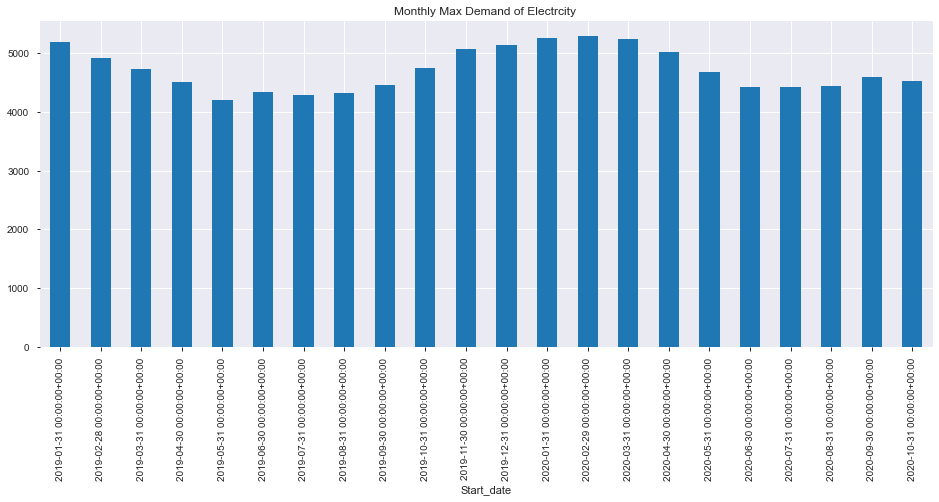

In [24]:
title = 'Monthly Max Demand of Electrcity '
dem_df_daily['Day_Ahead_Load'].resample('M').max().plot.bar(figsize=(16,6), title=title,color='#1f77b4');

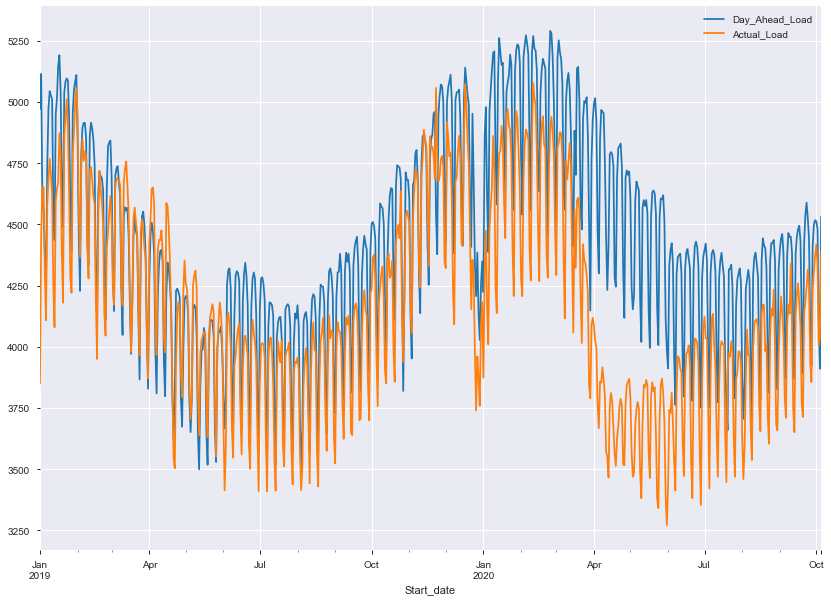

In [25]:
dem_df_daily.plot(figsize=(14,10));

In [26]:
dem_day_ahead=pd.DataFrame(dem_df_daily['Day_Ahead_Load'])
dem_actual=pd.DataFrame(dem_df_daily['Actual_Load'])

In [19]:
dem_actual

,Actual_Load
Start_date,
2019-01-01 00:00:00+00:00,3849.916667
2019-01-02 00:00:00+00:00,4456.562500
2019-01-03 00:00:00+00:00,4654.666667
2019-01-04 00:00:00+00:00,4650.895833
2019-01-05 00:00:00+00:00,4299.791667
...,...
2020-12-27 00:00:00+00:00,3219.000000
2020-12-28 00:00:00+00:00,3219.000000
2020-12-29 00:00:00+00:00,3219.000000


In [84]:
dem_day_ahead['2-Day_mean Day_Ahead_Load']=dem_day_ahead['Day_Ahead_Load'].rolling(window=2).mean().round(2)
dem_day_ahead['7-Day_mean Day_Ahead_Load'] = dem_day_ahead['Day_Ahead_Load'].rolling(window=7).mean().round(2)
dem_day_ahead['14-Day_mean Day_Ahead_Load'] = dem_day_ahead['Day_Ahead_Load'].rolling(window=14).mean().round(2)


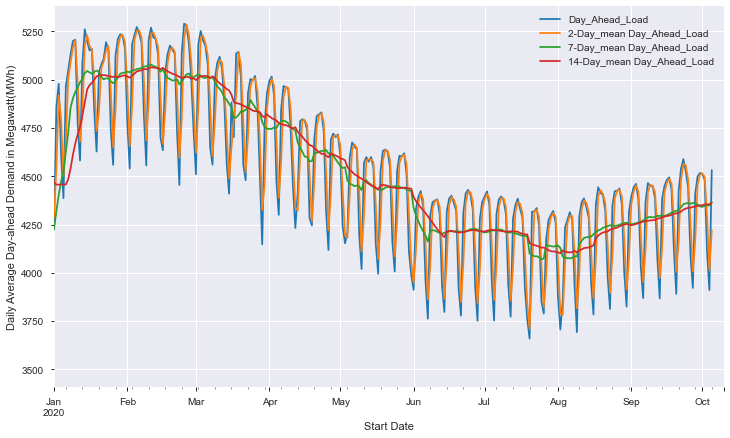

In [87]:
dem_day_ahead.plot(figsize=(12,7),xlim=['2020-01-01','2020-10-10'],
                  xlabel='Start Date', ylabel= 'Daily Average Day-ahead Demand in Megawatt(MWh)');

In [ ]:
dem_day_ahead.plot(figsize=(12,7));

In [29]:
result = seasonal_decompose(dem_day_ahead['Day_Ahead_Load'])

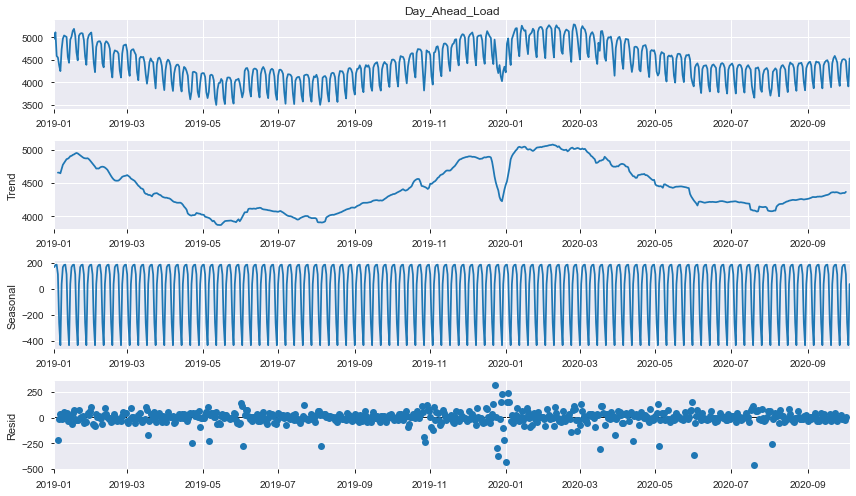

In [30]:
from pylab import rcParams
rcParams['figure.figsize'] =12,7
result.plot();

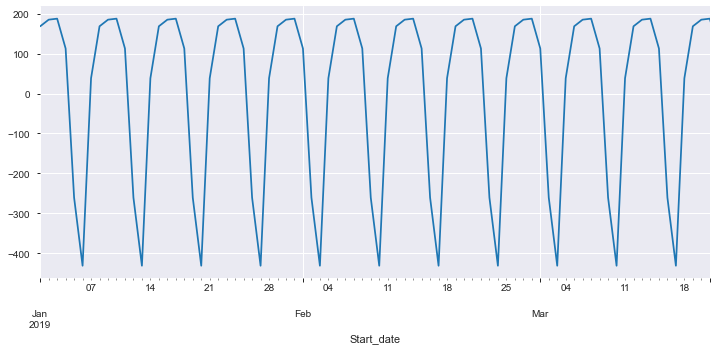

In [31]:
result.seasonal.plot(figsize = (12,5), xlim=['2019-01-01','2019-03-21']);

In [34]:
train_dem = pd.DataFrame(dem_day_ahead['Day_Ahead_Load'].loc['2019-04-01':'2020-09-30'])
test_dem = pd.DataFrame(dem_day_ahead['Day_Ahead_Load'].loc['2020-10-01':'2020-10-05'])

In [35]:
test_dem

,Day_Ahead_Load
Start_date,
2020-10-01 00:00:00+00:00,4512.187500
2020-10-02 00:00:00+00:00,4480.541667
2020-10-03 00:00:00+00:00,4112.833333
2020-10-04 00:00:00+00:00,3910.458333
2020-10-05 00:00:00+00:00,4532.020833


In [36]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

In [37]:
fitted_model = ExponentialSmoothing(train_dem['Day_Ahead_Load'], seasonal='add',
                                    seasonal_periods=7).fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


In [38]:
test_prediction=fitted_model.forecast(5)

In [39]:
test_prediction

2020-10-01 00:00:00+00:00    4525.575481
2020-10-02 00:00:00+00:00    4456.848919
2020-10-03 00:00:00+00:00    4081.019759
2020-10-04 00:00:00+00:00    3909.987035
2020-10-05 00:00:00+00:00    4374.274601
Freq: D, dtype: float64

<AxesSubplot:xlabel='Start_date'>

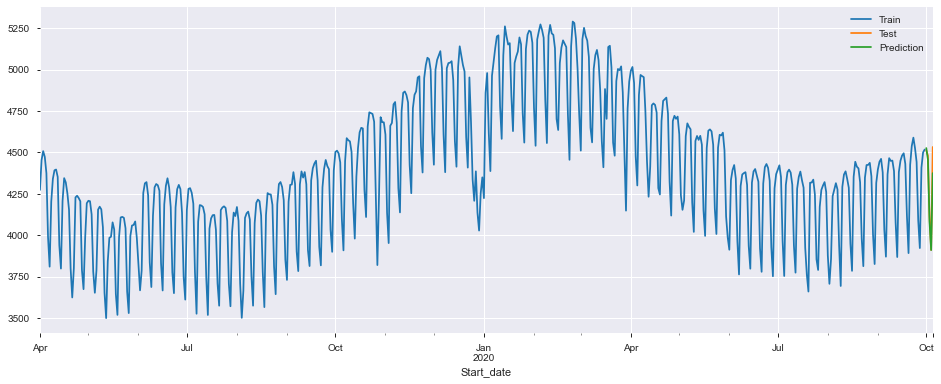

In [40]:
train_dem['Day_Ahead_Load'].plot(legend = True, label = 'Train', figsize=(16,6))
test_dem['Day_Ahead_Load'].plot(legend = True, label = 'Test')
test_prediction.plot(legend = True, label = 'Prediction')

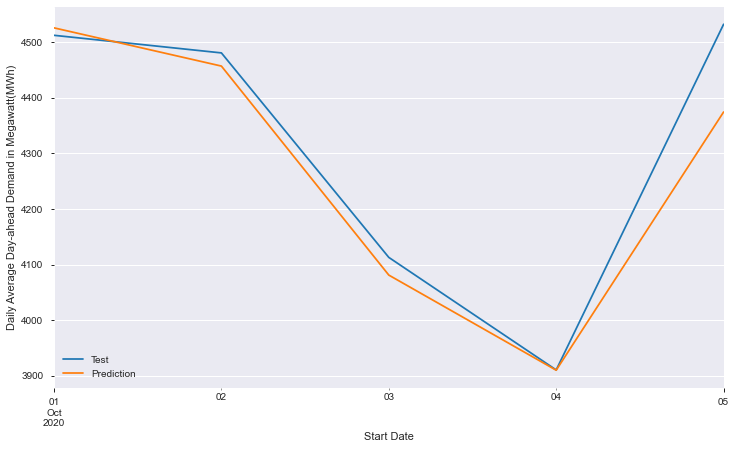

In [101]:
test_dem['Day_Ahead_Load'].plot(legend = True, label = 'Test')
test_prediction.plot(legend = True, label = 'Prediction',xlabel='Start Date', ylabel= 'Daily Average Day-ahead Demand in Megawatt(MWh)');

In [42]:
test_dem['Day_Ahead_Load'].describe()

count       5.000000
mean     4309.608333
std       281.853227
min      3910.458333
25%      4112.833333
50%      4480.541667
75%      4512.187500
max      4532.020833
Name: Day_Ahead_Load, dtype: float64

In [43]:
print(mean_absolute_error(test_dem['Day_Ahead_Load'],test_prediction))
print(mean_squared_error(test_dem['Day_Ahead_Load'],test_prediction))
print(np.sqrt(mean_squared_error(test_dem['Day_Ahead_Load'],test_prediction)))

45.422366751622214
5327.356749949908
72.98874399487846


In [44]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

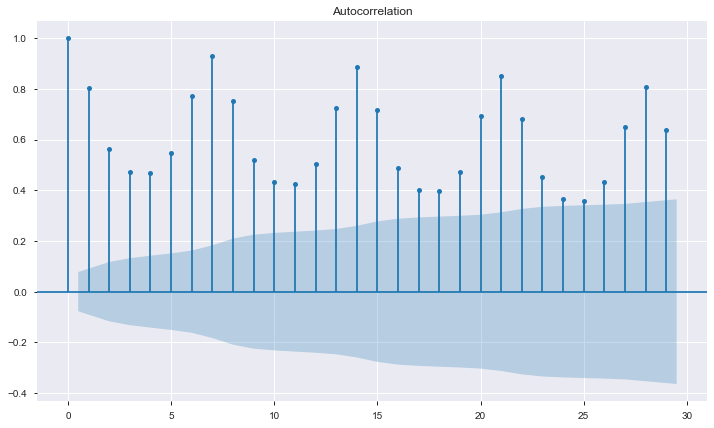

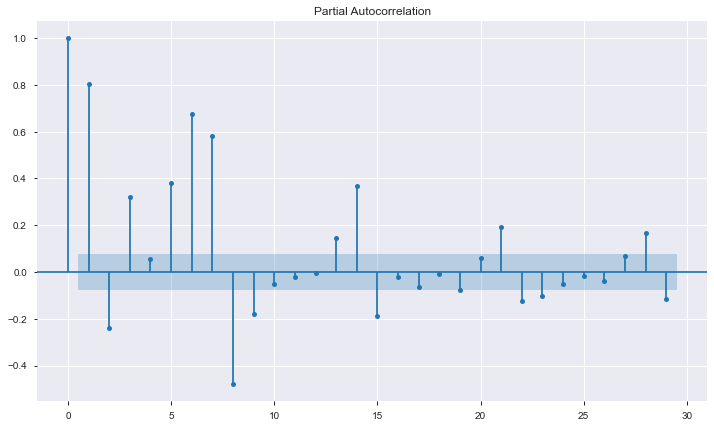

In [45]:
plot_acf(dem_day_ahead['Day_Ahead_Load']);
plot_pacf(dem_day_ahead['Day_Ahead_Load']);

In [46]:
from statsmodels.tsa.ar_model import AR, ARResults

In [47]:
import warnings
warnings.filterwarnings('ignore')

In [48]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [49]:
train_dem_ar = train_dem['Day_Ahead_Load']
train_dem_ar=pd.DataFrame(data=train_dem_ar)

In [50]:
test_dem_ar = test_dem['Day_Ahead_Load']
test_dem_ar=pd.DataFrame(data=test_dem_ar)

In [51]:
test_dem_ar

,Day_Ahead_Load
Start_date,
2020-10-01 00:00:00+00:00,4512.187500
2020-10-02 00:00:00+00:00,4480.541667
2020-10-03 00:00:00+00:00,4112.833333
2020-10-04 00:00:00+00:00,3910.458333
2020-10-05 00:00:00+00:00,4532.020833


In [52]:
pred_start_date= test_dem_ar.index[0]
pred_end_date = test_dem_ar.index[-1]

In [53]:
arima_1_model = AR(train_dem_ar['Day_Ahead_Load'])

In [54]:
arima_1_model_fit = arima_1_model.fit(maxlag=1)

In [55]:
prediction_AR1= arima_1_model_fit.predict(start=pred_start_date, end =pred_end_date)

<AxesSubplot:xlabel='Start Date', ylabel='Daily Average Day-ahead Demand in Euro/ Megawatt(MWh)'>

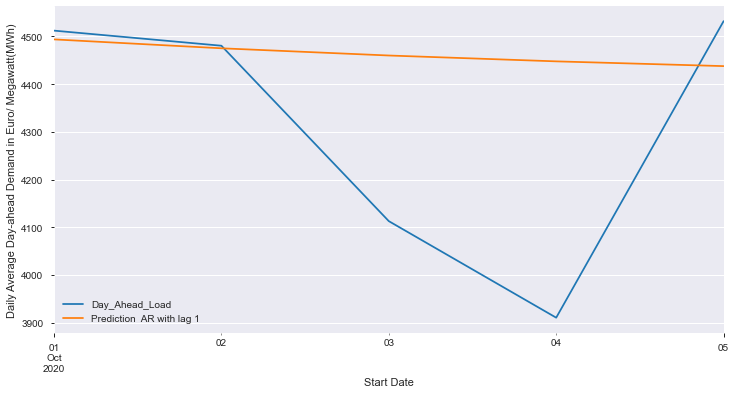

In [56]:
test_dem_ar.plot(figsize=(12,6), legend= True, label= 'Test data')
prediction_AR1.plot(legend =True, label = 'Prediction  AR with lag 1',xlabel='Start Date', ylabel= 'Daily Average Day-ahead Demand in Megawatt(MWh)')

In [57]:
# AR model with lag 1
print('Mean Absolute Error of ARIMA model :',mean_absolute_error(test_dem_ar['Day_Ahead_Load'],prediction_AR1))
print('Mean Squared Error of ARIMA model :',mean_squared_error(test_dem_ar['Day_Ahead_Load'],prediction_AR1))
print('Root Mean Squared Error of ARIMA model :',np.sqrt(mean_squared_error(test_dem_ar['Day_Ahead_Load'],prediction_AR1)))

Mean Absolute Error of ARIMA model : 200.4975923901141
Mean Squared Error of ARIMA model : 83699.42264305238
Root Mean Squared Error of ARIMA model : 289.30852500929245


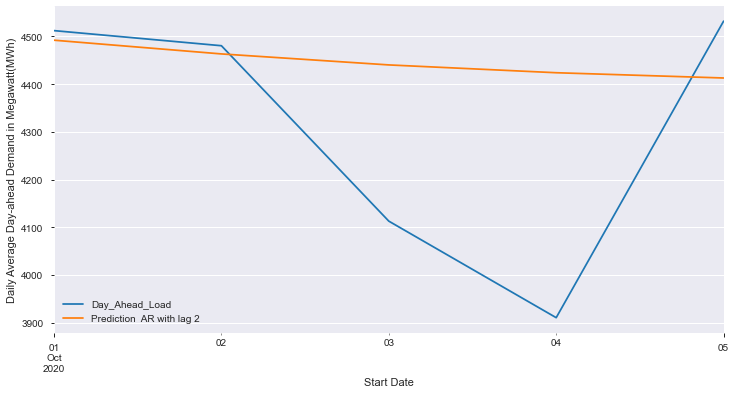

In [88]:
arima_2_model = AR(train_dem_ar['Day_Ahead_Load'])
arima_2_model_fit = arima_2_model.fit(maxlag=2)
prediction_AR2= arima_2_model_fit.predict(start=pred_start_date, end =pred_end_date)
test_dem_ar.plot(figsize=(12,6), legend= True)
prediction_AR2.plot(legend =True, label = 'Prediction  AR with lag 2',xlabel='Start Date', ylabel= 'Daily Average Day-ahead Demand in Megawatt(MWh)');

In [59]:
# AR model with lag 2
print('Mean Absolute Error of ARIMA model :',mean_absolute_error(test_dem_ar['Day_Ahead_Load'],prediction_AR2))
print('Mean Squared Error of ARIMA model :',mean_squared_error(test_dem_ar['Day_Ahead_Load'],prediction_AR2))
print('Root Mean Squared Error of ARIMA model :',np.sqrt(mean_squared_error(test_dem_ar['Day_Ahead_Load'],prediction_AR2)))

Mean Absolute Error of ARIMA model : 199.46364010222123
Mean Squared Error of ARIMA model : 77154.39179520411
Root Mean Squared Error of ARIMA model : 277.76679390309437


In [60]:
ar_final_model = AR(train_dem_ar['Day_Ahead_Load'])
ar_final_model_fit = ar_final_model.fit(ic='aic')
ar_final_model_fit.params

const                 68.964803
L1.Day_Ahead_Load      0.588050
L2.Day_Ahead_Load      0.070250
L3.Day_Ahead_Load      0.060507
L4.Day_Ahead_Load      0.063805
L5.Day_Ahead_Load      0.067227
L6.Day_Ahead_Load      0.103979
L7.Day_Ahead_Load      0.368015
L8.Day_Ahead_Load     -0.272894
L9.Day_Ahead_Load     -0.154954
L10.Day_Ahead_Load    -0.017610
L11.Day_Ahead_Load    -0.065152
L12.Day_Ahead_Load    -0.099797
L13.Day_Ahead_Load    -0.019427
L14.Day_Ahead_Load     0.481266
L15.Day_Ahead_Load    -0.188831
dtype: float64

In [93]:
prediction_AR15= ar_final_model_fit.predict(start=pred_start_date, end =pred_end_date)

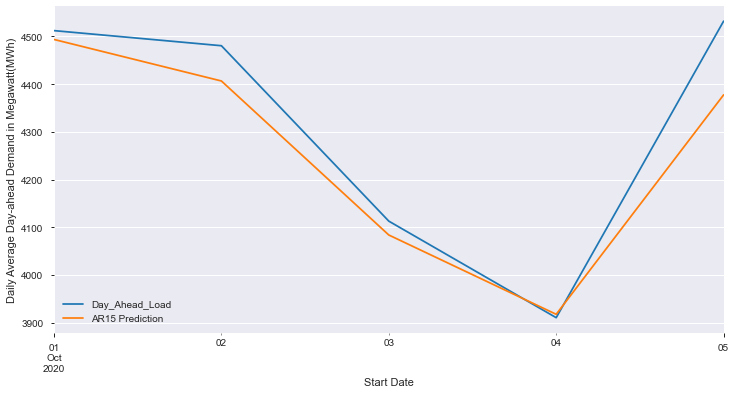

In [95]:
test_dem_ar.plot(figsize=(12,6), legend= True)
prediction_AR15.plot(legend =True, label = 'AR15 Prediction',xlabel='Start Date', ylabel= 'Daily Average Day-ahead Demand in Megawatt(MWh)');

In [96]:
# AR model with lag 18
print('Mean Absolute Error of ARIMA model :',mean_absolute_error(test_dem_ar['Day_Ahead_Load'],prediction_AR15))
print('Mean Squared Error of ARIMA model :',mean_squared_error(test_dem_ar['Day_Ahead_Load'],prediction_AR15))
print('Root Mean Squared Error of ARIMA model :',np.sqrt(mean_squared_error(test_dem_ar['Day_Ahead_Load'],prediction_AR15)))

Mean Absolute Error of ARIMA model : 56.61669000543088
Mean Squared Error of ARIMA model : 6115.818437605724
Root Mean Squared Error of ARIMA model : 78.20369836270996


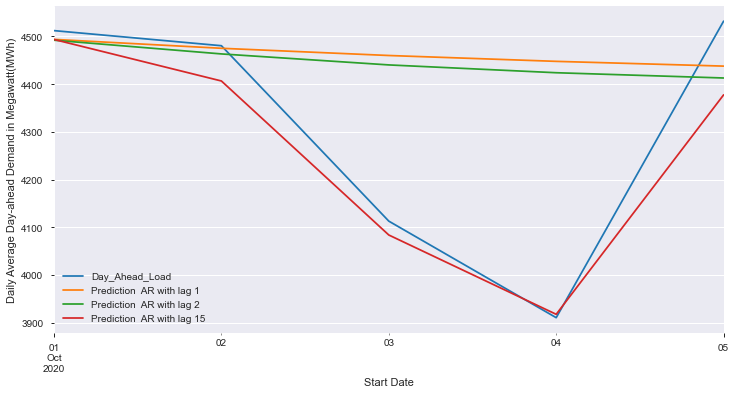

In [97]:
test_dem_ar.plot(figsize=(12,6), legend= True, label = 'Test Data')
prediction_AR1.plot(legend =True, label = 'Prediction  AR with lag 1')
prediction_AR2.plot(legend =True, label = 'Prediction  AR with lag 2')
prediction_AR15.plot(legend =True, label = 'Prediction  AR with lag 15',xlabel='Start Date', ylabel= 'Daily Average Day-ahead Demand in Megawatt(MWh)');

In [65]:
# Stationarity Test.

In [98]:
from statsmodels.tsa.stattools import adfuller

In [99]:
adfuller(train_dem['Day_Ahead_Load'])

(-1.4518056501369083,
 0.5572035912263509,
 19,
 529,
 {'1%': -3.442772146350605,
  '5%': -2.8670191055991836,
  '10%': -2.5696881663873414},
 6412.217935956931)

In [100]:
adfuller(train_dem['Day_Ahead_Load'].diff().dropna())

(-7.2675096411515385,
 1.6204579327667418e-10,
 19,
 528,
 {'1%': -3.4427957890025533,
  '5%': -2.867029512430173,
  '10%': -2.5696937122646926},
 6376.814270706816)

In [69]:
# resDiff = sm.tsa.arma_order_select_ic(train_dem['Day_Ahead_Load'], max_ar=7, max_ma=7, ic='aic',)
# print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

In [73]:
model = pm.auto_arima(train_dem['Day_Ahead_Load'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=9, max_q=7, # maximum p and q
                      ic='aic',              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7652.844, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7647.214, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7628.974, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7650.846, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7603.706, Time=0.59 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7380.540, Time=1.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7547.303, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=7377.469, Time=1.52 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=7541.091, Time=0.25 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=7249.161, Time=1.89 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=7447.289, Time=0.35 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=7040.485, Time=1.67 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=7108.759, Time=0.48 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=6855.637, Time=3.14 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept

In [70]:
arima_model = ARIMA(train_dem_ar['Day_Ahead_Load'], order=(7,0,1), freq='D')

In [71]:
arima_model_fit = arima_model.fit()

In [72]:
prediction_arima = arima_model_fit.predict(start=pred_start_date, end =pred_end_date)

In [102]:
prediction_arima

2020-10-01 00:00:00+00:00    4505.988403
2020-10-02 00:00:00+00:00    4438.272622
2020-10-03 00:00:00+00:00    4108.523071
2020-10-04 00:00:00+00:00    3997.050868
2020-10-05 00:00:00+00:00    4362.786694
Freq: D, dtype: float64

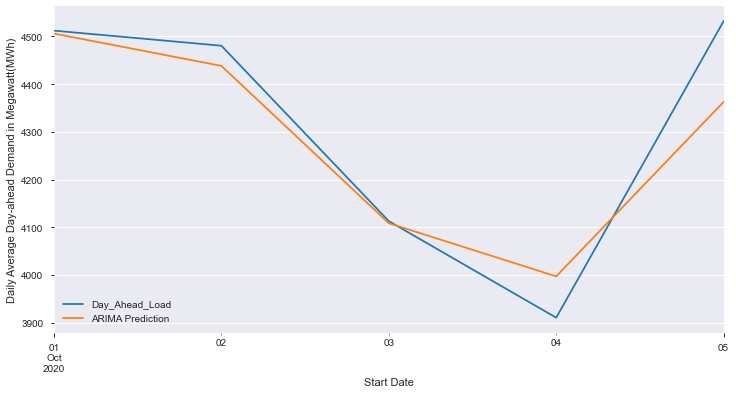

In [103]:
test_dem_ar.plot(figsize=(12,6), legend= True, label= 'Test data')
prediction_arima.plot(legend =True, label = 'ARIMA Prediction',xlabel='Start Date', ylabel= 'Daily Average Day-ahead Demand in Megawatt(MWh)');

In [75]:
# ARIMA model with order of (5,0,5)
print('Mean Absolute Error of ARIMA model :',mean_absolute_error(test_dem['Day_Ahead_Load'],prediction_arima))
print('Mean Squared Error of ARIMA model :',mean_squared_error(test_dem['Day_Ahead_Load'],prediction_arima))
print('Root Mean Squared Error of ARIMA model :',np.sqrt(mean_squared_error(test_dem['Day_Ahead_Load'],prediction_arima)))

Mean Absolute Error of ARIMA model : 61.72101563771794
Mean Squared Error of ARIMA model : 7596.428018606535
Root Mean Squared Error of ARIMA model : 87.15748974475191


In [76]:
auto_model = auto_arima(train_dem_ar,start_p=0,start_q=0, max_p=9, max_q=5, start_P=0, start_Q=0,m=7, seasonal= True)

KeyboardInterrupt: 

In [86]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  549
Model:             SARIMAX(4, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -3265.337
Date:                           Mon, 30 Nov 2020   AIC                           6548.674
Time:                                   22:10:49   BIC                           6587.431
Sample:                                        0   HQIC                          6563.822
                                           - 549                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.004     -0.067      0.947      -0.007       0.007
ar.L1          0.6391      0.023     27.595      0.000       0.594       0.684
ar.L2          0.1014      0.045      2.243      0.025       0.013       0.190
ar.L3          0.0381      0.052      0.727      0.467      -0.065       0.141
ar.L4          0.1364      0.045      3.036      0.002       0.048       0.224
ma.L1         -0.9851      0.012    -80.891      0.000      -1.009      -0.961
ar.S.L7        0.9974      0.001    669.628      0.000       0.995       1.000
ma.S.L7       -0.8619      0.023    -37.152      0.000      -0.907      -0.816
sigma2      8543.7157    227.640     37.532      0.000    8097.549    8989.883
===================================================================================
Ljung-Box (Q):                       41.35   Jarque-Bera (JB):              2556.18
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               1.74   Skew:                            -0.94
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [78]:
sarima_model = sm.tsa.statespace.SARIMAX(train_dem_ar['Day_Ahead_Load'],
                                order=(4,1,1),
                                seasonal_order=(1, 0, 1, 7),)
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6358      0.020     31.900      0.000       0.597       0.675
ar.L2          0.1375      0.040      3.406      0.001       0.058       0.217
ar.L3          0.0558      0.050      1.121      0.262      -0.042       0.153
ar.L4          0.1415      0.040      3.547      0.000       0.063       0.220
ma.L1         -0.9998      0.010    -99.687      0.000      -1.019      -0.980
ar.S.L7        0.9997      0.000   3353.689      0.000       0.999       1.000
ma.S.L7       -0.9247      0.017    -54.471      0.000      -0.958      -0.891
sigma2      8176.7175    202.946     40.290      0.000    7778.950    8574.485


In [79]:
sarima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                    Day_Ahead_Load   No. Observations:                  549
Model:             SARIMAX(4, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -3261.563
Date:                           Tue, 01 Dec 2020   AIC                           6539.127
Time:                                   23:51:18   BIC                           6573.577
Sample:                               04-01-2019   HQIC                          6552.591
                                    - 09-30-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6358      0.020     31.900      0.000       0.597       0.675
ar.L2          0.1375      0.040      3.406      0.001       0.058       0.217
ar.L3          0.0558      0.050      1.121      0.262      -0.042       0.153
ar.L4          0.1415      0.040      3.547      0.000       0.063       0.220
ma.L1         -0.9998      0.010    -99.687      0.000      -1.019      -0.980
ar.S.L7        0.9997      0.000   3353.689      0.000       0.999       1.000
ma.S.L7       -0.9247      0.017    -54.471      0.000      -0.958      -0.891
sigma2      8176.7175    202.946     40.290      0.000    7778.950    8574.485
===================================================================================
Ljung-Box (Q):                       42.59   Jarque-Bera (JB):              3092.13
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               1.77   Skew:                            -0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [81]:
prediction_sarima = sarima_model_fit.predict(start=pred_start_date, end =pred_end_date)

<AxesSubplot:xlabel='Start Date', ylabel='Daily Average Day-ahead Demand in Euro/ Megawatt(MWh)'>

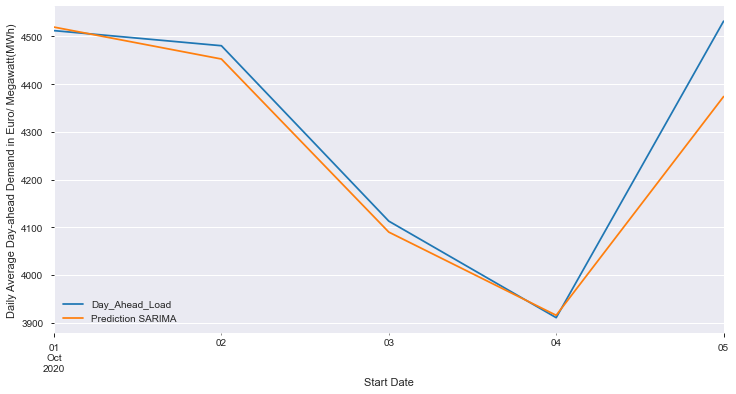

In [92]:
test_dem_ar.plot(figsize=(12,6), legend= True)
prediction_sarima.plot(legend = True ,label = 'Prediction SARIMA',xlabel='Start Date', ylabel= 'Daily Average Day-ahead Demand in Euro/ Megawatt(MWh)')

In [83]:
# SARIMA model with order of (1,1,1)
print('Mean Absolute Error of ARIMA model :',mean_absolute_error(test_dem['Day_Ahead_Load'],prediction_sarima))
print('Mean Squared Error of ARIMA model :',mean_squared_error(test_dem['Day_Ahead_Load'],prediction_sarima))
print('Root Mean Squared Error of ARIMA model :',np.sqrt(mean_squared_error(test_dem['Day_Ahead_Load'],prediction_sarima)))

Mean Absolute Error of ARIMA model : 44.24360481720733
Mean Squared Error of ARIMA model : 5271.3608083903855
Root Mean Squared Error of ARIMA model : 72.60413768092275


In [107]:
test_dem.std().round(2)

Day_Ahead_Load    281.85
dtype: float64

# Forecasting using SARIMA model

In [104]:
forecast_df = pd.DataFrame(dem_day_ahead['Day_Ahead_Load'].loc['2019-04-01':'2020-10-05'])

In [105]:
forecast_sarima = sm.tsa.statespace.SARIMAX(forecast_df,
                                order=(4,1,1),
                                seasonal_order=(1, 0, 1, 7),)
forecast_sarima_fit = forecast_sarima.fit()
print(forecast_sarima_fit.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6402      0.020     32.145      0.000       0.601       0.679
ar.L2          0.1101      0.041      2.678      0.007       0.030       0.191
ar.L3          0.0604      0.051      1.180      0.238      -0.040       0.161
ar.L4          0.1573      0.043      3.691      0.000       0.074       0.241
ma.L1         -0.9991      0.003   -393.478      0.000      -1.004      -0.994
ar.S.L7        0.9997      0.000   3941.533      0.000       0.999       1.000
ma.S.L7       -0.9363      0.016    -58.064      0.000      -0.968      -0.905
sigma2      8346.6776    215.585     38.716      0.000    7924.138    8769.217


In [106]:
forecast_prediction = forecast_sarima_fit.predict(start=len(forecast_df), end =len(forecast_df)+5).rename('Forecast')

In [107]:
forecast_prediction

2020-10-06 00:00:00+00:00    4612.226815
2020-10-07 00:00:00+00:00    4614.786481
2020-10-08 00:00:00+00:00    4602.720112
2020-10-09 00:00:00+00:00    4547.797098
2020-10-10 00:00:00+00:00    4183.509658
2020-10-11 00:00:00+00:00    4006.327213
Freq: D, Name: Forecast, dtype: float64

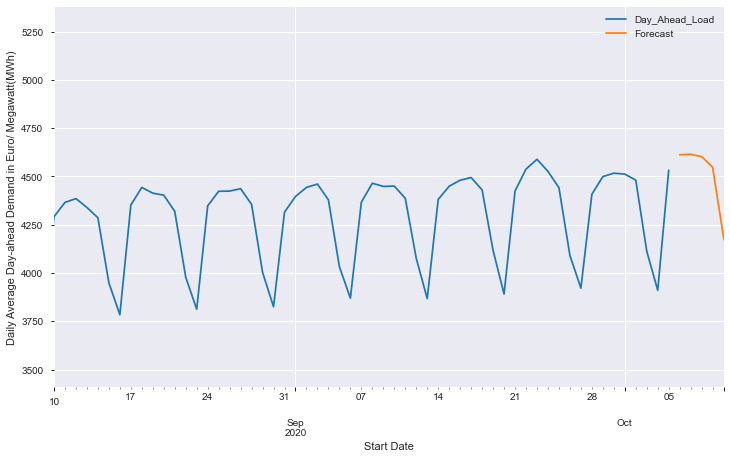

In [108]:
forecast_df['Day_Ahead_Load'].plot(legend = True)
forecast_prediction.plot(legend = True, label = 'Forecast', xlim=['2020-08-10','2020-10-10'],
                         xlabel='Start Date', ylabel= 'Daily Average Day-ahead Demand in Euro/ Megawatt(MWh)');